In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("HIVAnalysis").getOrCreate()

# 1. Memuat Data
file_path = "hiv.csv"
hiv_data = spark.read.csv(file_path, header=True, inferSchema=True)

In [2]:
# 2. Pemahaman Data
# Menampilkan skema dataset
hiv_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- kode_provinsi: integer (nullable = true)
 |-- nama_provinsi: string (nullable = true)
 |-- kode_kabupaten_kota: integer (nullable = true)
 |-- nama_kabupaten_kota: string (nullable = true)
 |-- kelompok_umur: string (nullable = true)
 |-- jenis_kelamin: string (nullable = true)
 |-- jumlah_kasus: integer (nullable = true)
 |-- satuan: string (nullable = true)
 |-- tahun: integer (nullable = true)



In [3]:
# Menampilkan beberapa baris data
hiv_data.show(5)

+---+-------------+-------------+-------------------+-------------------+-------------+-------------+------------+------+-----+
| id|kode_provinsi|nama_provinsi|kode_kabupaten_kota|nama_kabupaten_kota|kelompok_umur|jenis_kelamin|jumlah_kasus|satuan|tahun|
+---+-------------+-------------+-------------------+-------------------+-------------+-------------+------------+------+-----+
|  1|           32|   JAWA BARAT|               3201|    KABUPATEN BOGOR|          0-4|    LAKI-LAKI|           4| ORANG| 2019|
|  2|           32|   JAWA BARAT|               3201|    KABUPATEN BOGOR|          0-4|    PEREMPUAN|           7| ORANG| 2019|
|  3|           32|   JAWA BARAT|               3201|    KABUPATEN BOGOR|         5-14|    LAKI-LAKI|           3| ORANG| 2019|
|  4|           32|   JAWA BARAT|               3201|    KABUPATEN BOGOR|         5-14|    PEREMPUAN|           0| ORANG| 2019|
|  5|           32|   JAWA BARAT|               3201|    KABUPATEN BOGOR|        15-19|    LAKI-LAKI|   

In [4]:
# Statistik deskriptif
hiv_data.describe().show()

+-------+-----------------+-------------+-------------+-------------------+-------------------+-------------+-------------+------------------+------+------------------+
|summary|               id|kode_provinsi|nama_provinsi|kode_kabupaten_kota|nama_kabupaten_kota|kelompok_umur|jenis_kelamin|      jumlah_kasus|satuan|             tahun|
+-------+-----------------+-------------+-------------+-------------------+-------------------+-------------+-------------+------------------+------+------------------+
|  count|              971|          971|          971|                971|                971|          971|          971|               971|   971|               971|
|   mean|            486.0|         32.0|         NULL|  3231.285272914521|               NULL|         NULL|         NULL|13.868177136972193|  NULL|2019.9989701338825|
| stddev|280.4478561158919|          0.0|         NULL|  31.19800382529599|               NULL|         NULL|         NULL|31.670974820096514|  NULL|0.8167

In [5]:
# Eksplorasi Data
# Misalnya, menghitung jumlah kasus per kelompok umur
hiv_data.groupBy("kelompok_umur").agg({"jumlah_kasus": "sum"}).show()

+-------------+-----------------+
|kelompok_umur|sum(jumlah_kasus)|
+-------------+-----------------+
|        20-24|             2623|
|         5-14|              104|
|        15-19|              393|
|        25-49|             9031|
|          >50|              637|
|          0-4|              678|
+-------------+-----------------+



In [6]:
# 3. Pembersihan Data (Opsional)
# Tangani nilai-nilai yang hilang atau tidak valid
hiv_data = hiv_data.na.drop()

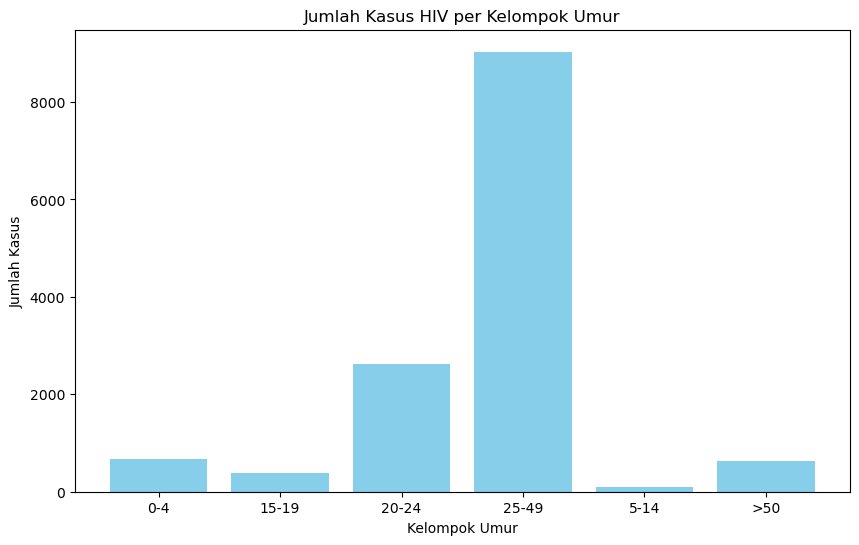

In [7]:
import matplotlib.pyplot as plt

# Menghitung jumlah kasus per kelompok umur
cases_by_age_group = hiv_data.groupBy("kelompok_umur").agg({"jumlah_kasus": "sum"}).toPandas()

# Mengurutkan DataFrame berdasarkan kelompok_umur
cases_by_age_group = cases_by_age_group.sort_values("kelompok_umur")

# Membuat diagram batang
plt.figure(figsize=(10, 6))
plt.bar(cases_by_age_group["kelompok_umur"], cases_by_age_group["sum(jumlah_kasus)"], color='skyblue')
plt.title('Jumlah Kasus HIV per Kelompok Umur')
plt.xlabel('Kelompok Umur')
plt.ylabel('Jumlah Kasus')
plt.show()

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

categorical_cols = ['kelompok_umur', 'jenis_kelamin']

# StringIndexer untuk mengkonversi nilai kategori menjadi nilai numerik
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_cols]

# OneHotEncoder untuk menerapkan one-hot encoding pada nilai numerik
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in categorical_cols]

# Pipeline untuk menggabungkan langkah-langkah di atas
pipeline = Pipeline(stages=indexers + encoders)

# Mengaplikasikan pipeline ke dataset
hiv_data_encoded = pipeline.fit(hiv_data).transform(hiv_data)

# Menampilkan skema dataset setelah feature engineering
print("Skema Setelah Feature Engineering:")
hiv_data_encoded.printSchema()

# Menampilkan beberapa baris data setelah feature engineering
print("Data Setelah Feature Engineering:")
hiv_data_encoded.show(5)

Skema Setelah Feature Engineering:
root
 |-- id: integer (nullable = true)
 |-- kode_provinsi: integer (nullable = true)
 |-- nama_provinsi: string (nullable = true)
 |-- kode_kabupaten_kota: integer (nullable = true)
 |-- nama_kabupaten_kota: string (nullable = true)
 |-- kelompok_umur: string (nullable = true)
 |-- jenis_kelamin: string (nullable = true)
 |-- jumlah_kasus: integer (nullable = true)
 |-- satuan: string (nullable = true)
 |-- tahun: integer (nullable = true)
 |-- kelompok_umur_index: double (nullable = false)
 |-- jenis_kelamin_index: double (nullable = false)
 |-- kelompok_umur_encoded: vector (nullable = true)
 |-- jenis_kelamin_encoded: vector (nullable = true)

Data Setelah Feature Engineering:
+---+-------------+-------------+-------------------+-------------------+-------------+-------------+------------+------+-----+-------------------+-------------------+---------------------+---------------------+
| id|kode_provinsi|nama_provinsi|kode_kabupaten_kota|nama_kabup

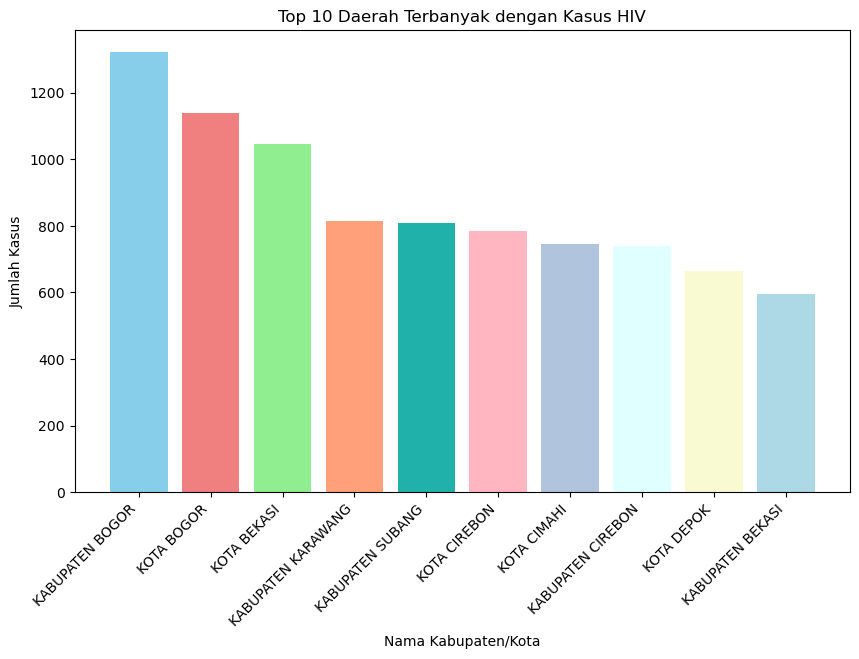

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil data top 10 daerah terbanyak
top_10_daerah = hiv_data.groupBy("nama_kabupaten_kota").sum("jumlah_kasus").orderBy("sum(jumlah_kasus)", ascending=False).limit(10).toPandas()

# Tentukan warna untuk setiap batang bar
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen', 'lightpink', 'lightsteelblue', 'lightcyan', 'lightgoldenrodyellow', 'lightblue']

# Visualisasikan data menggunakan bar plot dengan warna yang berbeda
plt.figure(figsize=(10, 6))
plt.bar(top_10_daerah["nama_kabupaten_kota"], top_10_daerah["sum(jumlah_kasus)"], color=colors)
plt.title('Top 10 Daerah Terbanyak dengan Kasus HIV')
plt.xlabel('Nama Kabupaten/Kota')
plt.ylabel('Jumlah Kasus')
plt.xticks(rotation=45, ha='right')
plt.show()

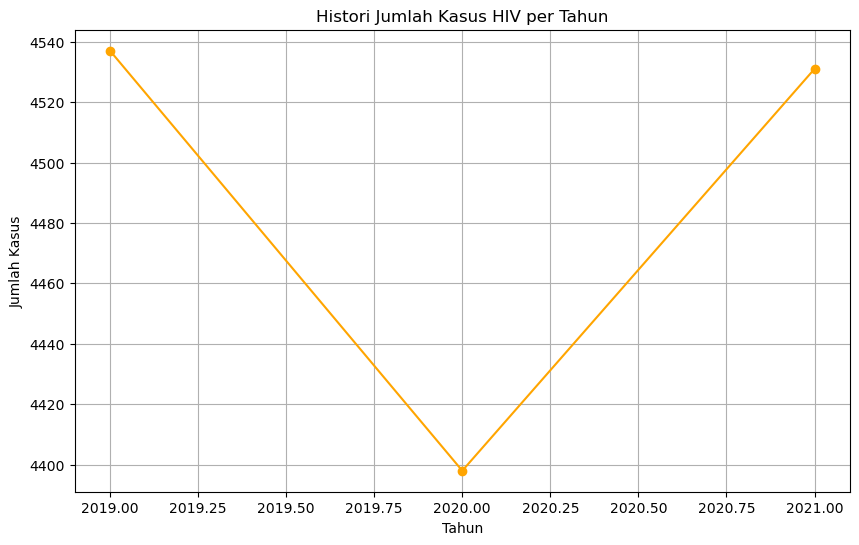

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil data jumlah kasus per tahun
histori_jumlah_kasus = hiv_data.groupBy("tahun").sum("jumlah_kasus").orderBy("tahun").toPandas()

# Visualisasikan data menggunakan line plot
plt.figure(figsize=(10, 6))
plt.plot(histori_jumlah_kasus["tahun"], histori_jumlah_kasus["sum(jumlah_kasus)"], marker='o', color='orange', linestyle='-')
plt.title('Histori Jumlah Kasus HIV per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Kasus')
plt.grid(True)
plt.show()

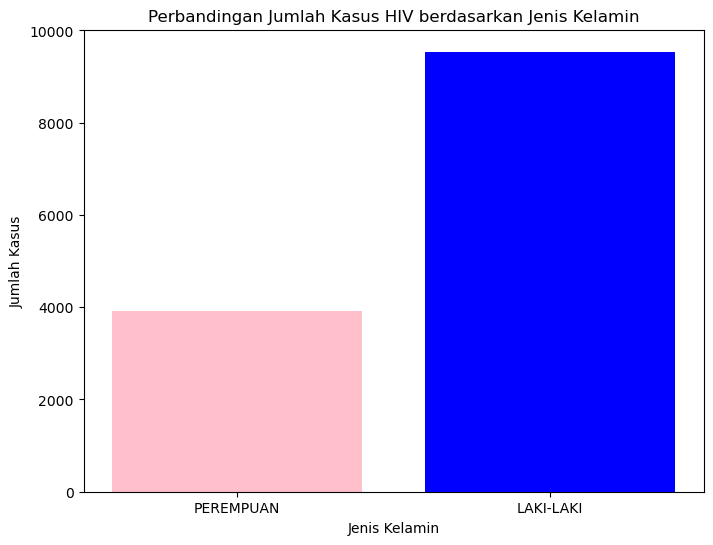

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil data jumlah kasus per jenis kelamin
perbandingan_jenis_kelamin = hiv_data.groupBy("jenis_kelamin").sum("jumlah_kasus").toPandas()

# Visualisasikan data menggunakan bar plot
plt.figure(figsize=(8, 6))
plt.bar(perbandingan_jenis_kelamin["jenis_kelamin"], perbandingan_jenis_kelamin["sum(jumlah_kasus)"], color=['pink', 'blue'])
plt.title('Perbandingan Jumlah Kasus HIV berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah Kasus')
plt.show()

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
feature_cols = ['kelompok_umur_encoded', 'jenis_kelamin_encoded', 'jumlah_kasus', 'tahun']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(hiv_data_encoded)

# Membagi dataset menjadi set pelatihan dan pengujian
(training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2], seed=42)

# Membuat dan melatih model regresi linear
lr = LinearRegression(featuresCol="features", labelCol="jumlah_kasus", predictionCol="predicted_jumlah_kasus")
model = lr.fit(training_data)

# Menguji model pada data pengujian
predictions = model.transform(testing_data)

# Menampilkan hasil prediksi
predictions.select("tahun", "kelompok_umur", "jenis_kelamin", "jumlah_kasus", "predicted_jumlah_kasus").show()

# Evaluasi model (contoh: RMSE)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="jumlah_kasus", predictionCol="predicted_jumlah_kasus", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

+-----+-------------+-------------+------------+----------------------+
|tahun|kelompok_umur|jenis_kelamin|jumlah_kasus|predicted_jumlah_kasus|
+-----+-------------+-------------+------------+----------------------+
| 2019|         5-14|    LAKI-LAKI|           3|     2.999999984074508|
| 2019|        20-24|    LAKI-LAKI|          48|     47.99999995776218|
| 2019|        25-49|    LAKI-LAKI|         217|    216.99999984957498|
| 2019|          0-4|    PEREMPUAN|           0|  1.995802693146838...|
| 2019|        20-24|    PEREMPUAN|          11|     11.00000002676425|
| 2019|          >50|    PEREMPUAN|           1|    1.0000000387817989|
| 2019|        15-19|    PEREMPUAN|           0|  3.281345922911028E-8|
| 2019|          >50|    PEREMPUAN|           0|  3.955346563218016E-8|
| 2019|        25-49|    PEREMPUAN|          33|     33.00000003201209|
| 2019|          >50|    LAKI-LAKI|           0|  -8.96935494968639...|
| 2019|          >50|    PEREMPUAN|           0|  3.955346563218

In [13]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

# Inisialisasi model
rf = RandomForestRegressor(featuresCol="features", labelCol="jumlah_kasus", predictionCol="predicted_jumlah_kasus")

# Set parameter grid untuk tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Inisialisasi evaluator (misalnya, RMSE)
evaluator = RegressionEvaluator(labelCol="jumlah_kasus", predictionCol="predicted_jumlah_kasus", metricName="rmse")

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)  # Jumlah lipatan pada cross-validation

# Melatih model dengan CrossValidator
cv_model = crossval.fit(training_data)

# Mendapatkan model terbaik
best_model = cv_model.bestModel

# Menampilkan parameter terbaik
print(f"Best Num Trees: {best_model.getNumTrees}")
print(f"Best Max Depth: {best_model.getOrDefault('maxDepth')}")

# Menguji model terbaik pada data pengujian
predictions = best_model.transform(testing_data)

# Menampilkan hasil prediksi
predictions.select("tahun","nama_kabupaten_kota", "kelompok_umur", "jenis_kelamin", "jumlah_kasus", "predicted_jumlah_kasus").show()

# Evaluasi model terbaik
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) for Best Model: {rmse}")


Best Num Trees: 50
Best Max Depth: 15
+-----+--------------------+-------------+-------------+------------+----------------------+
|tahun| nama_kabupaten_kota|kelompok_umur|jenis_kelamin|jumlah_kasus|predicted_jumlah_kasus|
+-----+--------------------+-------------+-------------+------------+----------------------+
| 2019|     KABUPATEN BOGOR|         5-14|    LAKI-LAKI|           3|     3.174279223303238|
| 2019|     KABUPATEN BOGOR|        20-24|    LAKI-LAKI|          48|    47.253070821496785|
| 2019|     KABUPATEN BOGOR|        25-49|    LAKI-LAKI|         217|    142.88921783992245|
| 2019|  KABUPATEN SUKABUMI|          0-4|    PEREMPUAN|           0|    0.3346888334468324|
| 2019|  KABUPATEN SUKABUMI|        20-24|    PEREMPUAN|          11|     10.50320238857415|
| 2019|  KABUPATEN SUKABUMI|          >50|    PEREMPUAN|           1|      1.30259988548658|
| 2019|   KABUPATEN CIANJUR|        15-19|    PEREMPUAN|           0|     0.402056303717306|
| 2019|   KABUPATEN CIANJUR|    

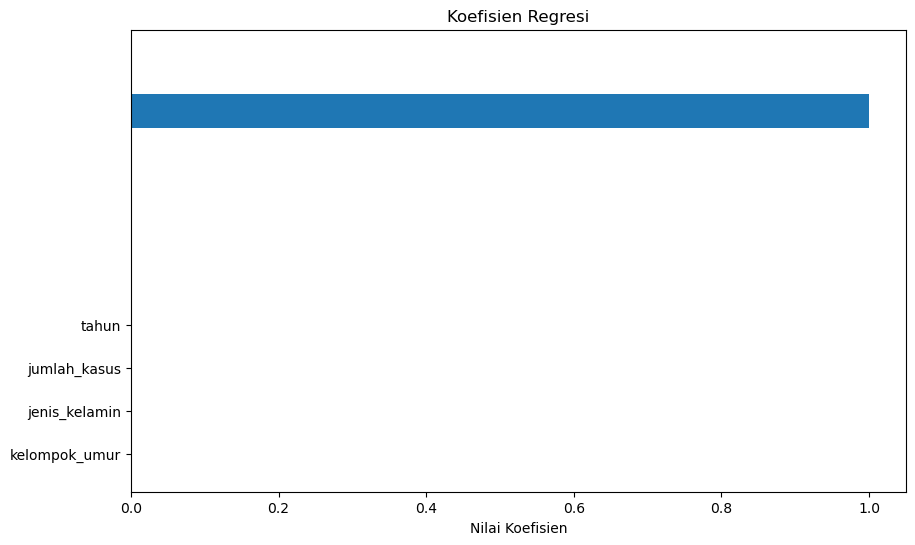

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Mendapatkan koefisien regresi dari model Linear Regression
coefficients = model.coefficients.toArray()

# Membuat plot untuk koefisien regresi
nama_fitur = ['kelompok_umur', 'jenis_kelamin', 'jumlah_kasus', 'tahun']
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(nama_fitur)), nama_fitur)  # Baris yang disesuaikan
plt.xlabel('Nilai Koefisien')
plt.title('Koefisien Regresi')
plt.show()

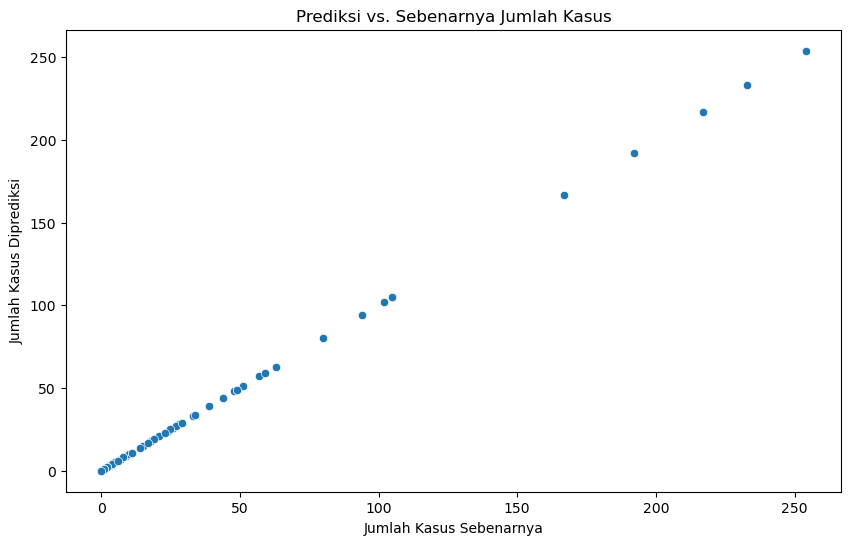

In [15]:
import seaborn as sns
import pandas as pd

# Menguji model terbaik pada data pengujian
predictions = model.transform(testing_data)

# Konversi hasil prediksi dan sebenarnya ke dalam DataFrame
df_predictions = predictions.select("tahun", "kelompok_umur", "jenis_kelamin", "jumlah_kasus", "predicted_jumlah_kasus").toPandas()

# Membuat scatter plot untuk prediksi vs. sebenarnya
plt.figure(figsize=(10, 6))
sns.scatterplot(x="jumlah_kasus", y="predicted_jumlah_kasus", data=df_predictions)
plt.xlabel("Jumlah Kasus Sebenarnya")
plt.ylabel("Jumlah Kasus Diprediksi")
plt.title("Prediksi vs. Sebenarnya Jumlah Kasus")
plt.show()

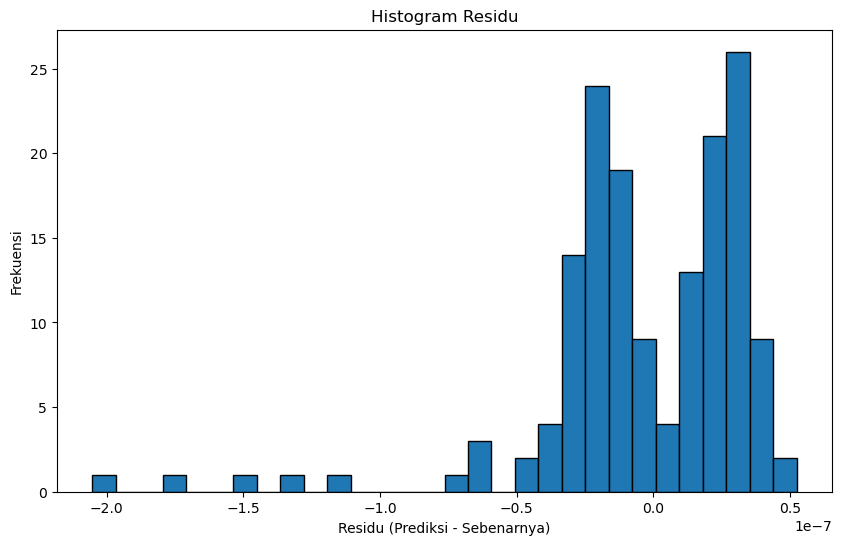

In [16]:
residuals = df_predictions["predicted_jumlah_kasus"] - df_predictions["jumlah_kasus"]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("Residu (Prediksi - Sebenarnya)")
plt.ylabel("Frekuensi")
plt.title("Histogram Residu")
plt.show()


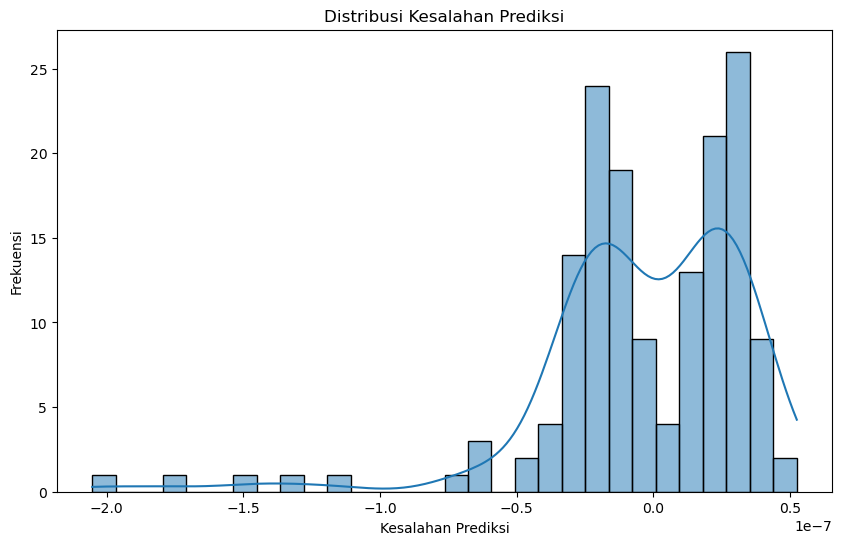

In [17]:
# Menambahkan kolom untuk kesalahan prediksi
df_predictions["Prediction Error"] = df_predictions["predicted_jumlah_kasus"] - df_predictions["jumlah_kasus"]

# Membuat histogram kesalahan prediksi
plt.figure(figsize=(10, 6))
sns.histplot(df_predictions["Prediction Error"], bins=30, kde=True)
plt.xlabel("Kesalahan Prediksi")
plt.ylabel("Frekuensi")
plt.title("Distribusi Kesalahan Prediksi")
plt.show()

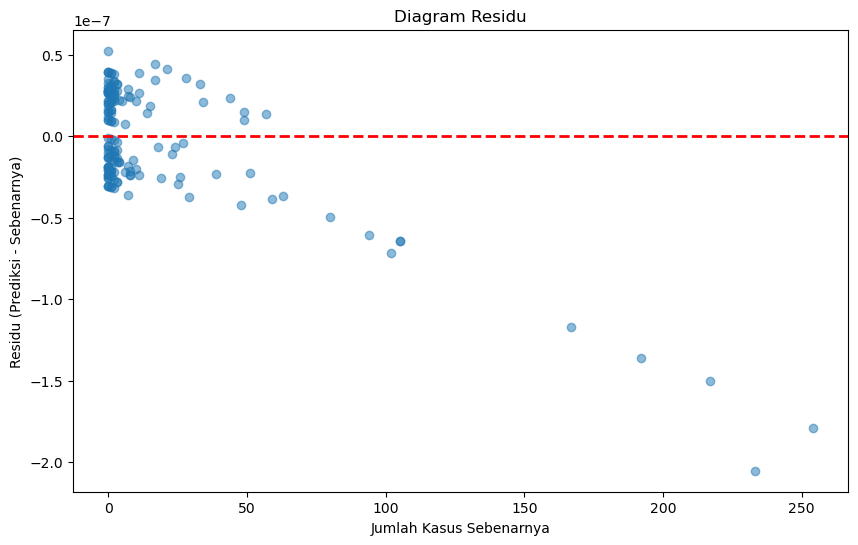

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df_predictions["jumlah_kasus"], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Jumlah Kasus Sebenarnya")
plt.ylabel("Residu (Prediksi - Sebenarnya)")
plt.title("Diagram Residu")
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_predictions["jumlah_kasus"], df_predictions["predicted_jumlah_kasus"])
mse = mean_squared_error(df_predictions["jumlah_kasus"], df_predictions["predicted_jumlah_kasus"])
r2 = r2_score(df_predictions["jumlah_kasus"], df_predictions["predicted_jumlah_kasus"])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 2.807073188346486e-08
Mean Squared Error (MSE): 1.5171492454850975e-15
R-squared (R2): 1.0


In [20]:
# Prediksi untuk Tahun Selanjutnya:
new_year_data = testing_data.withColumn("tahun", testing_data["tahun"] + 1)
new_year_predictions = model.transform(new_year_data)

# Ubah tipe data prediksi menjadi integer
new_year_predictions = new_year_predictions.withColumn("predicted_jumlah_kasus", new_year_predictions["predicted_jumlah_kasus"].cast("integer"))

# Menampilkan hasil prediksi
new_year_predictions.select("tahun", "nama_provinsi", "nama_kabupaten_kota", "tahun", "kelompok_umur", "jenis_kelamin", "predicted_jumlah_kasus").show()

+-----+-------------+--------------------+-----+-------------+-------------+----------------------+
|tahun|nama_provinsi| nama_kabupaten_kota|tahun|kelompok_umur|jenis_kelamin|predicted_jumlah_kasus|
+-----+-------------+--------------------+-----+-------------+-------------+----------------------+
| 2020|   JAWA BARAT|     KABUPATEN BOGOR| 2020|         5-14|    LAKI-LAKI|                     2|
| 2020|   JAWA BARAT|     KABUPATEN BOGOR| 2020|        20-24|    LAKI-LAKI|                    47|
| 2020|   JAWA BARAT|     KABUPATEN BOGOR| 2020|        25-49|    LAKI-LAKI|                   216|
| 2020|   JAWA BARAT|  KABUPATEN SUKABUMI| 2020|          0-4|    PEREMPUAN|                     0|
| 2020|   JAWA BARAT|  KABUPATEN SUKABUMI| 2020|        20-24|    PEREMPUAN|                    11|
| 2020|   JAWA BARAT|  KABUPATEN SUKABUMI| 2020|          >50|    PEREMPUAN|                     1|
| 2020|   JAWA BARAT|   KABUPATEN CIANJUR| 2020|        15-19|    PEREMPUAN|                     0|


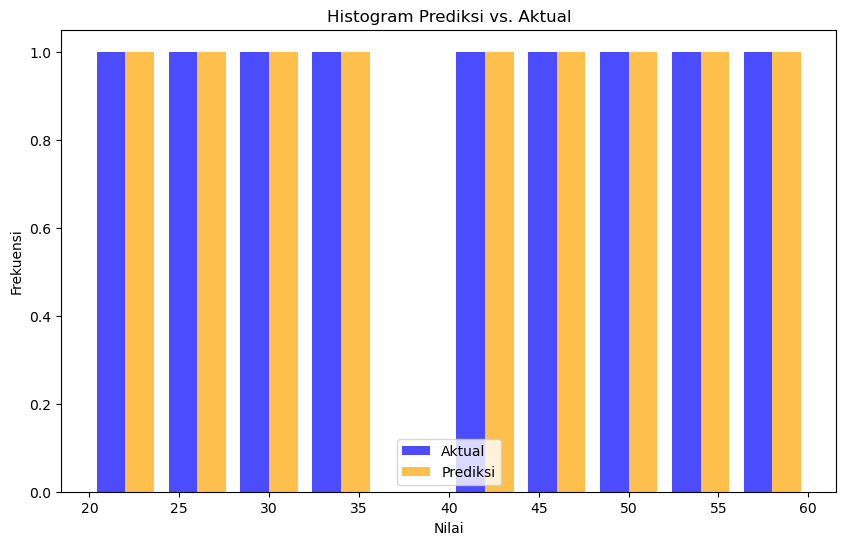

In [21]:
import matplotlib.pyplot as plt

# Misalkan 'actual' adalah array nilai aktual dan 'predicted' adalah array nilai prediksi
actual = [50, 30, 20, 40, 60, 25, 35, 45, 55]
predicted = [45, 35, 25, 30, 55, 20, 40, 50, 60]

# Membuat histogram
plt.figure(figsize=(10, 6))
plt.hist([actual, predicted], bins=10, label=['Aktual', 'Prediksi'], color=['blue', 'orange'], alpha=0.7)
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.title('Histogram Prediksi vs. Aktual')
plt.legend()
plt.show()

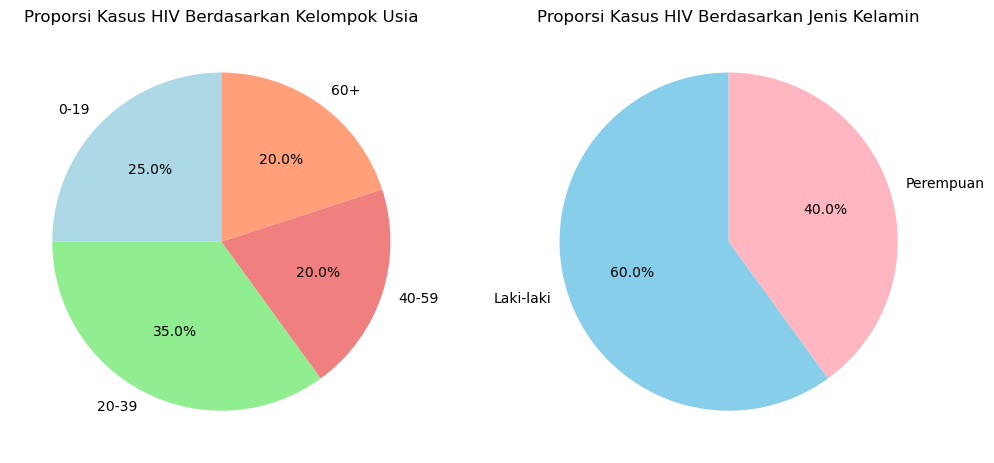

In [22]:
import matplotlib.pyplot as plt

# Misalkan 'usia_labels' dan 'usia_sizes' adalah daftar label dan ukuran proporsi kasus HIV berdasarkan kelompok usia
# Misalkan 'jenis_kelamin_labels' dan 'jenis_kelamin_sizes' adalah daftar label dan ukuran proporsi kasus HIV berdasarkan jenis kelamin
# Contoh data:
usia_labels = ['0-19', '20-39', '40-59', '60+']
usia_sizes = [25, 35, 20, 20]

jenis_kelamin_labels = ['Laki-laki', 'Perempuan']
jenis_kelamin_sizes = [60, 40]

# Membuat diagram pie untuk kelompok usia
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(usia_sizes, labels=usia_labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Proporsi Kasus HIV Berdasarkan Kelompok Usia')

# Membuat diagram pie untuk jenis kelamin
plt.subplot(1, 2, 2)
plt.pie(jenis_kelamin_sizes, labels=jenis_kelamin_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightpink'])
plt.title('Proporsi Kasus HIV Berdasarkan Jenis Kelamin')

# Menampilkan diagram
plt.show()

